In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!pip install tf2cv tensorflow>=2.0.0

In [0]:
from tensorflow.python.client import device_lib
dev=device_lib.list_local_devices()
dev[len(dev)-1]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1085515694940873083
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"

In [0]:
#global consts
IMG_SIZE='224x224'
HEIGHT = 224
WIDTH = 224
BATCH_SIZE=96
DROP_OUT=0.0
FOLD=0
TRAIN_DIR = './train/'
TRAIN_IMG_DIR=TRAIN_DIR+str(IMG_SIZE)
EPOCHS = 200
STATS_FS = (0.055029564364430086, 0.17228061284674265)
STATS_128 = (0.0692, 0.2051)
STATS_224 = (0.05488200794579805,0.16995901757803655)
EXPERIMENT='sernext_g3gen_cw_224x224'
INPUT_DIR ='/content/drive/My Drive/kaggle/bengali/input/'
OUTPUT_DIR = '/content/drive/My Drive/kaggle/bengali/output/'
IMPORT_DIR = '/content/drive/My Drive/kaggle/bengali/nbs/'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'
CHKP_DIR = EXPERIMENT_DIR+'chkp/'
OUTPUT_SUBDIR = ''
DATASET_224='bengali-224x224-wocrop.zip'
DATASET_128='grapheme-imgs-128x128.zip'
DATASET_FS = 'bengali-full-size.zip'
TRAIN_WITH_FOLD = 'train_with_fold_20.csv'
PRETRAINED = False
PRETRAINED_WEIGHTS = ''
LOG_FILE = EXPERIMENT_DIR+'log_'+EXPERIMENT+'.csv'
#INITIAL_EPOCH=40
#HEAD_WD=1e-3
#BACKBONE_WD = 1e-4

if IMG_SIZE == 128: DATASET=DATASET_128
if IMG_SIZE == '224x224': DATASET=DATASET_224
if IMG_SIZE == '137x236' : DATASET=DATASET_FS


#lr sheduler consts
LR_MAX = 0.001
LR_MIN = 0.00001
T_MAX = 100

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append(IMPORT_DIR+'py/models/')
sys.path.append(IMPORT_DIR+'py/utils/')
sys.path.append(IMPORT_DIR+'py/callbacks/')
sys.path.append(IMPORT_DIR+'py/opts/')

In [0]:
#import local modules
#from mish import Mish,mish
from generators import *
from kaggle_metric import *
#from cosine import CosineAnnealingScheduler
from kagglevalidation import KaggleValidationFS
#from lookahead import Lookahead
from se_resnext50 import build_se_resnext50_model_fs_wod
#from md121v2 import build_md121_v2_model
#from losses import categorical_focal_loss


#import external modules
import numpy as np 
import pandas as pd 

import os
import errno

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight

In [0]:
try:
  os.mkdir(TRAIN_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_DIR+' already exists')
    else:
        raise
try:
  os.mkdir(TRAIN_IMG_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_IMG_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(EXPERIMENT_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(EXPERIMENT_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(CHKP_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(CHKP_DIR+' already exists')
    else:
        raise


os.system('cp '+ '"'+INPUT_DIR+DATASET+'" ' + TRAIN_DIR)
os.system('cp '+ '"'+INPUT_DIR+TRAIN_WITH_FOLD+'" ' + TRAIN_DIR)

/content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/ already exists
/content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ already exists


0

In [0]:
if PRETRAINED: os.system('cp '+ '"'+OUTPUT_DIR+OUTPUT_SUBDIR+PRETRAINED_WEIGHTS+'" '+TRAIN_DIR)

In [0]:
os.system('unzip -q '+TRAIN_DIR+DATASET+ ' -d '+ TRAIN_IMG_DIR)

0

In [0]:
!ls train

224x224  bengali-224x224-wocrop.zip  train_with_fold_20.csv


In [0]:
dataset_np = pd.read_csv(TRAIN_DIR+TRAIN_WITH_FOLD).to_numpy()
dataset_np[:,0]+='.png'
dataset_m = dataset_np.shape[0]


valid_m = np.where(dataset_np[:,6]==FOLD)[0].shape[0]
train_m = dataset_m-valid_m

fold_train_inds = np.where(dataset_np[:,6] != FOLD)
fold_valid_inds = np.where(dataset_np[:,6] == FOLD)

train_np = dataset_np[fold_train_inds]
valid_np = dataset_np[fold_valid_inds]

train_df = pd.DataFrame(train_np)
valid_df = pd.DataFrame(valid_np)

train_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)
valid_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)

train_df.drop(columns=[5,6], inplace=True)
valid_df.drop(columns=[5,6], inplace=True)

In [0]:
cons_unique=np.unique(train_np[:,3])
cons_y_train = train_np[:,3]
vowel_unique=np.unique(train_np[:,2])
vowel_y_train = train_np[:,2]
root_unique =np.unique(train_np[:,1])
root_y_train = train_np[:,1]

cons_class_weights = class_weight.compute_class_weight('balanced',
                                                 cons_unique,
                                                 cons_y_train)

vowel_class_weights = class_weight.compute_class_weight('balanced',
                                                 vowel_unique,
                                                 vowel_y_train)

root_class_weights = class_weight.compute_class_weight('balanced',
                                                 root_unique,
                                                 root_y_train)
cons_cw_dict=dict(enumerate(cons_class_weights))
vowel_cw_dict=dict(enumerate(vowel_class_weights))
root_cw_dict=dict(enumerate(root_class_weights))

model_cw={}
model_cw['root']=root_cw_dict
model_cw['vowel']=vowel_cw_dict
model_cw['consonant']=cons_cw_dict

In [0]:
model =  build_se_resnext50_model_fs_wod(height=HEIGHT, width=WIDTH)

In [0]:
if 0: model.summary()

In [0]:
if 1:
  from tensorflow.keras.utils import plot_model
  plot_model(model, to_file=OUTPUT_DIR+'model3.png',show_shapes=True)

In [0]:
!ls

'=2.0.0'   drive   sample_data


In [0]:
if 0:
  for (n, layer) in enumerate(model.layers[1].layers):
    if 'activation' in layer.get_config() and layer.get_config()['activation'] == 'relu':
      print('replacing #{}: {}, {}'.format(n, layer, layer.activation))
      layer.activation = Mish(mish)
      print('-> {}'.format(layer.activation))

In [0]:
TRAIN_DIR+PRETRAINED_WEIGHTS

'./train/'

In [0]:
cutout_datagen = ImageDataGenerator(rotation_range = 15,
                                   preprocessing_function=get_random_eraser(s_l=0.05,s_h=0.25,r_1=0.8,r_2=1.2,v_l=0,v_h=0))

mcm_datagen = ImageDataGenerator()

In [0]:
columns=["root_class","vowel_class", "cons_class"]

mcm_generator1 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

mcm_generator2 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")


cutout_generator = cutout_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

Found 190798 validated image filenames.
Found 190798 validated image filenames.
Found 190798 validated image filenames.


In [0]:
def rand_bbox(size, lam):
    H = size[1]
    W = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [0]:
def cutmix_batches_fs2(batch1,batch2,alpha=1.0,h=137,w=236,st=STATS_FS):
    x1,y1 = prep_batch_fs(batch1,st=st)
    x2,y2 = prep_batch_fs(batch2,st=st)

    bs = x1.shape[0]
    assert(bs == x2.shape[0])

    shape = x1.shape
    

    y1_root =  y1[0]
    y1_vowel = y1[1]
    y1_cons =  y1[2]

    y2_root =  y2[0]
    y2_vowel = y2[1]
    y2_cons =  y2[2]

  
    cut_ratio = np.random.beta(alpha, alpha, bs)
    label_ratio = cut_ratio.reshape(bs, 1)

    x = x1
    for i in range(bs):
        bx1,by1,bx2,by2 = rand_bbox(shape,cut_ratio[i])
        x[i,by1:by2,bx1:bx2,:] = x2[i,by1:by2, bx1:bx2,:]
            
    y_root =  y1_root *  label_ratio  + y2_root *  (1-label_ratio)
    y_vowel = y1_vowel * label_ratio  + y2_vowel * (1-label_ratio)
    y_cons =  y1_cons *  label_ratio  + y2_cons *  (1-label_ratio)


    return x,[y_root,y_vowel,y_cons]

In [0]:
def g3_generator_fs2(gen1,gen2, gen3,h=137,w=236,st=STATS_FS):
    while True:
        p = np.random.rand()
        if p>0.5:
            batch = next(gen3)
            x_res,y_res = prep_batch_fs(batch,st=st)
        else:
            batch1 = next(gen1)
            batch2 = next(gen2)
            q = np.random.rand()
            if q>0.5:
                x_res,y_res = mix_batches_fs(batch1,batch2,st=st)
            else:
                x_res,y_res = cutmix_batches_fs2(batch1,batch2,h=h,w=w,st=st)
        yield x_res,y_res

In [0]:
if 0:
  mixup_datagen=mixup_data_gen(aux_data_gen(mcm_generator1),aux_data_gen(mcm_generator2))
  cutout_datagen=aux_data_gen(cutout_generator)
  h_datagen=hybrid_data_gen(mixup_datagen,cutout_datagen)
  h2_datagen=h_generator(mcm_generator1,mcm_generator2,cutout_generator)
  hmcm_datagen=hmcm_generator(mcm_generator1,mcm_generator2)
  g3_datagen = g3_generator(mcm_generator1,mcm_generator2,cutout_generator)
  g3_datagen_fs = g3_generator_fs(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_FS)
  cpsm_datagen_fs = cpsm_generator_fs(mcm_generator1,mcm_generator2,cutout_generator, st=STATS_FS)
  g3_datagen_fs = g3_generator_fs(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_224)

g3_datagen_fs2 = g3_generator_fs2(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_224)

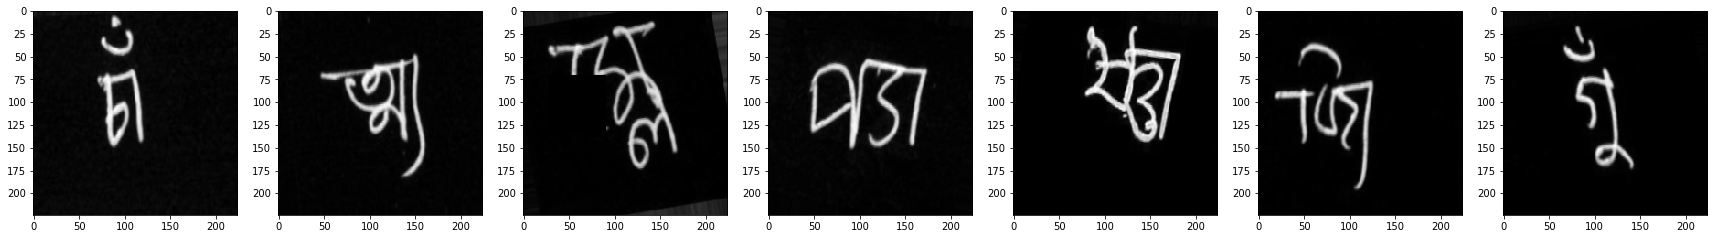

In [0]:
if 1: 
  batch_x,y = next(g3_datagen_fs2)
  import matplotlib.pyplot as plt
  fig, axs = plt.subplots(1, 7, figsize=(30, 30))
  for i in range(7):
    axs[i].imshow(batch_x[i,:,:,0], cmap='gray')
  plt.show()

In [0]:
if 0: opt = Lookahead(tf.keras.optimizers.SGD(learning_rate=LR_MAX, momentum=0.9,nesterov=True))

opt=tf.keras.optimizers.Adam(learning_rate=LR_MAX)

In [0]:
checkpoint =  tf.train.Checkpoint(latest_epoch=tf.Variable(0), optimizer=opt, model=model)
chkp_manager =  tf.train.CheckpointManager(checkpoint, CHKP_DIR, max_to_keep=3)

In [0]:
chkp_manager.latest_checkpoint

'/content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-125'

In [0]:
chkp_restore_status=checkpoint.restore(chkp_manager.latest_checkpoint)
#chkp_restore_status=checkpoint.restore('/content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-95')
if chkp_manager.latest_checkpoint:
  #chkp_restore_status.assert_consumed()
  print("Restored from {}".format(chkp_manager.latest_checkpoint))
  print(f"Lastest epoch {checkpoint.latest_epoch.numpy()}")
else:
  print("Initializing from scratch.")

Restored from /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-125
Lastest epoch 125


In [0]:
loss_dict={'root':    'categorical_crossentropy',
           'vowel':    'categorical_crossentropy',
           'consonant':'categorical_crossentropy'}
model.compile(optimizer=opt, loss=loss_dict, loss_weights=[2.0,1.0,1.0])

In [0]:
initial_epoch = checkpoint.latest_epoch.numpy()


print(f'epochs trained: {initial_epoch}. start training epoch {initial_epoch+1}...')
#ca_shed = CosineAnnealingScheduler(T_max=T_MAX, eta_max=LR_MAX, eta_min=LR_MIN,verbose=1, initial_epoch=initial_epoch-130)
rolrplt = tf.keras.callbacks.ReduceLROnPlateau(monitor='kaggle',mode='max', patience=5, verbose=1, factor=0.5, min_lr=LR_MIN)


suffix =EXPERIMENT+\
                '_eps'+str(EPOCHS)+\
                '_iniep'+str(initial_epoch)+\
                '_sz'+str(IMG_SIZE)+\
                '_bs'+str(BATCH_SIZE)+\
                '_do'+str(DROP_OUT)+\
                '_'+model.optimizer.get_config()['name']+\
                '_IS_fold'+str(FOLD)


kv = KaggleValidationFS(valid_df,
                      batch_size=512,
                      vals_per_epoch=1,
                      train_steps=train_m//BATCH_SIZE+1,
                      logfile=EXPERIMENT_DIR+'log_kr_'+suffix+'.csv',
                      initial_epoch=initial_epoch,
                      suffix = suffix,
                      train_img_dir=TRAIN_IMG_DIR,
                      output_dir=EXPERIMENT_DIR,
                      thresholds=[0.977,0.994,0.992],
                      chkp_manager=chkp_manager,
                      in_shape=[HEIGHT,WIDTH],
                      st=STATS_224)

tf.keras.backend.set_value(model.optimizer.lr, 0.0001)
cbs = [kv]

history=model.fit(g3_datagen_fs2,
                  epochs=EPOCHS,
                  steps_per_epoch=train_m//BATCH_SIZE+1,
                  callbacks=cbs,
                  class_weight=model_cw,
                  verbose=2)

epochs trained: 125. start training epoch 126...
Train for 1988 steps
Epoch 1/200

batch 1987: validation...



[0:31:19] - kaggle:0.9825 - root:0.9749 -vowel:0.9922 - cons: 0.9880

saved checkpoint for epoch 126: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-126

1988/1988 - 1882s - loss: 2.3950 - root_loss: 0.7816 - vowel_loss: 0.4487 - consonant_loss: 0.3831
Epoch 2/200

batch 1987: validation...



[1:02:08] - kaggle:0.9816 - root:0.9747 -vowel:0.9902 - cons: 0.9867

saved checkpoint for epoch 127: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-127

1988/1988 - 1849s - loss: 2.3421 - root_loss: 0.7658 - vowel_loss: 0.4369 - consonant_loss: 0.3735
Epoch 3/200

batch 1987: validation...



[1:32:51] - kaggle:0.9812 - root:0.9743 -vowel:0.9901 - cons: 0.9861

saved checkpoint for epoch 128: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-128

1988/1988 - 1843s - loss: 2.3117 - root_loss: 0.7584 - vowel_loss: 0.4342 - consonant_loss: 0.3608
Epoch 4/200

batch 1987: validation...



[2:03:34] - kaggle:0.9824 - root:0.9752 -vowel:0.9915 - cons: 0.9877

saved checkpoint for epoch 129: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-129

1988/1988 - 1843s - loss: 2.3065 - root_loss: 0.7538 - vowel_loss: 0.4269 - consonant_loss: 0.3719
Epoch 5/200

batch 1987: validation...



[2:34:14] - kaggle:0.9823 - root:0.9758 -vowel:0.9906 - cons: 0.9870

saved checkpoint for epoch 130: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-130

1988/1988 - 1840s - loss: 2.3029 - root_loss: 0.7592 - vowel_loss: 0.4249 - consonant_loss: 0.3596
Epoch 6/200

batch 1987: validation...



[3:04:55] - kaggle:0.9830 - root:0.9753 -vowel:0.9909 - cons: 0.9905

saved checkpoint for epoch 131: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-131

1988/1988 - 1841s - loss: 2.2795 - root_loss: 0.7497 - vowel_loss: 0.4267 - consonant_loss: 0.3534
Epoch 7/200

batch 1987: validation...



[3:35:38] - kaggle:0.9821 - root:0.9746 -vowel:0.9911 - cons: 0.9881

saved checkpoint for epoch 132: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-132

1988/1988 - 1843s - loss: 2.2844 - root_loss: 0.7528 - vowel_loss: 0.4256 - consonant_loss: 0.3531
Epoch 8/200

batch 1987: validation...



[4:06:23] - kaggle:0.9825 - root:0.9754 -vowel:0.9915 - cons: 0.9879

saved checkpoint for epoch 133: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-133

1988/1988 - 1845s - loss: 2.2324 - root_loss: 0.7277 - vowel_loss: 0.4140 - consonant_loss: 0.3629
Epoch 9/200

batch 1987: validation...



[4:37:07] - kaggle:0.9822 - root:0.9760 -vowel:0.9902 - cons: 0.9865

saved checkpoint for epoch 134: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-134

1988/1988 - 1843s - loss: 2.3235 - root_loss: 0.7629 - vowel_loss: 0.4317 - consonant_loss: 0.3660
Epoch 10/200

batch 1987: validation...



[5:07:55] - kaggle:0.9842 - root:0.9771 -vowel:0.9922 - cons: 0.9903
saving weights w_best_[r 0.97709] best combined kaggle recall: 0.9850452454232888...

saved checkpoint for epoch 135: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-135

1988/1988 - 1850s - loss: 2.2419 - root_loss: 0.7328 - vowel_loss: 0.4226 - consonant_loss: 0.3536
Epoch 11/200

batch 1987: validation...



[5:38:41] - kaggle:0.9794 - root:0.9750 -vowel:0.9885 - cons: 0.9791

saved checkpoint for epoch 136: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-136

1988/1988 - 1844s - loss: 2.2820 - root_loss: 0.7479 - vowel_loss: 0.4227 - consonant_loss: 0.3634
Epoch 12/200

batch 1987: validation...



[6:09:25] - kaggle:0.9817 - root:0.9754 -vowel:0.9919 - cons: 0.9842

saved checkpoint for epoch 137: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-137

1988/1988 - 1845s - loss: 2.1918 - root_loss: 0.7174 - vowel_loss: 0.4090 - consonant_loss: 0.3479
Epoch 13/200

batch 1987: validation...



[6:40:10] - kaggle:0.9832 - root:0.9752 -vowel:0.9919 - cons: 0.9905

saved checkpoint for epoch 138: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-138

1988/1988 - 1845s - loss: 2.2105 - root_loss: 0.7224 - vowel_loss: 0.4121 - consonant_loss: 0.3536
Epoch 14/200

batch 1987: validation...



[7:10:54] - kaggle:0.9828 - root:0.9758 -vowel:0.9916 - cons: 0.9880

saved checkpoint for epoch 139: /content/drive/My Drive/kaggle/bengali/output/sernext_g3gen_cw_224x224/chkp/ckpt-139

1988/1988 - 1845s - loss: 2.1697 - root_loss: 0.7144 - vowel_loss: 0.4038 - consonant_loss: 0.3371
Epoch 15/200


In [0]:
model.optimizer.get_config()